# Nous Showcase Notebook
This notebook demonstrates:
- NousNet Simple / Modern (classification + regression)
- NousNet interpretability: LOO rule impacts, enhanced explanations, MSE masks, fidelity/stability, global rulebook,
  pruning threshold selection, counterfactual suggestions, aggregator mixture report
- Prototype head (Modern classification) + prototype tracing reports
- NumPy export + parity validation
- Model Zoo: SoftLogitAND, SoftLogicInteraction, SegmentMoE, HierarchicalMoE, NousFamilies + their explanations

In [1]:
!pip -q install --upgrade pip
!pip -q install --default-timeout=100 "nous[dev,examples] @ git+https://github.com/EmotionEngineer/nous@main"
!pip -q install --default-timeout=100 tqdm scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import time
import random
import warnings
import tempfile
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils as nn_utils

pd.set_option("display.max_colwidth", None)
warnings.filterwarnings("ignore", category=UserWarning)

from nous import (
    set_global_seed,
    make_quantile_calibrators,
    # Core
    NousNet,
    # Training & evaluation
    train_model,
    # NousNet explainability
    generate_enhanced_explanation,
    rule_impact_df,
    minimal_sufficient_explanation,
    explanation_fidelity_metrics,
    explanation_stability,
    select_pruning_threshold_global,
    aggregator_mixture_report,
    suggest_rule_counterfactuals,
    global_rulebook,
    # Prototypes tracing
    prototype_contribution_df,
    prototype_report_global,
    # Export
    export_numpy_inference,
    load_numpy_module,
    validate_numpy_vs_torch,
    # Zoo models
    SoftLogitAND,
    SoftLogicInteraction,
    SegmentMoE,
    HierarchicalMoE,
    NousFamilies,
    # Zoo explainability
    softlogitand_global_rules_df,
    softlogitand_local_contrib_df,
    moe_gate_summary_df,
    segmentmoe_local_explain_df,
    hiermoe_local_explain_df,
    nousfamilies_global_summary_df,
    nousfamilies_local_contrib_df,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE, "| Torch:", torch.__version__)

Device: cuda | Torch: 2.8.0+cu126


In [3]:
def seed_everything(seed: int = 42) -> None:
    set_global_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

@torch.no_grad()
def predict_proba_clf(model: nn.Module, X: np.ndarray) -> np.ndarray:
    model.eval()
    xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    logits = model(xt)
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    return probs

@torch.no_grad()
def predict_reg(model: nn.Module, X: np.ndarray) -> np.ndarray:
    model.eval()
    xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    yhat = model(xt).detach().cpu().numpy().ravel()
    return yhat

def eval_binary_clf(model: nn.Module, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    probs = predict_proba_clf(model, X)
    p1 = probs[:, 1]
    pred = (p1 >= 0.5).astype(int)
    return {
        "acc": float(accuracy_score(y, pred)),
        "auc": float(roc_auc_score(y, p1)),
        "f1": float(f1_score(y, pred)),
    }

def eval_reg(model: nn.Module, X: np.ndarray, y: np.ndarray, y_scaler: Optional[StandardScaler] = None) -> Dict[str, float]:
    yhat = predict_reg(model, X)
    if y_scaler is not None:
        yhat_u = y_scaler.inverse_transform(yhat.reshape(-1, 1)).ravel()
        y_u = y_scaler.inverse_transform(y.reshape(-1, 1)).ravel()
    else:
        yhat_u, y_u = yhat, y

    rmse = float(np.sqrt(mean_squared_error(y_u, yhat_u)))
    mae = float(mean_absolute_error(y_u, yhat_u))
    r2 = float(r2_score(y_u, yhat_u))
    return {"rmse": rmse, "mae": mae, "r2": r2}

## 1) Datasets

In [4]:
def load_breast_cancer_data(seed: int = 42, test_size: float = 0.2, val_size: float = 0.2):
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target).astype(np.int64)  # 0=malignant, 1=benign

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size, stratify=y_trainval, random_state=seed
    )

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train).astype(np.float32)
    X_val_s   = scaler.transform(X_val).astype(np.float32)
    X_test_s  = scaler.transform(X_test).astype(np.float32)

    feature_names = list(X.columns)
    class_names = ["malignant", "benign"]
    return X_train_s, y_train.values, X_val_s, y_val.values, X_test_s, y_test.values, feature_names, class_names, scaler

def load_california_regression(seed: int = 42, test_size: float = 0.2, val_size: float = 0.2, scale_y: bool = True):
    data = fetch_california_housing()
    X = data.data.astype(np.float32)
    y = data.target.astype(np.float32)
    feature_names = list(data.feature_names)

    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_size, random_state=seed)

    x_scaler = StandardScaler()
    X_train = x_scaler.fit_transform(X_train).astype(np.float32)
    X_val   = x_scaler.transform(X_val).astype(np.float32)
    X_test  = x_scaler.transform(X_test).astype(np.float32)

    y_scaler = None
    if scale_y:
        y_scaler = StandardScaler()
        y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel().astype(np.float32)
        y_val   = y_scaler.transform(y_val.reshape(-1, 1)).ravel().astype(np.float32)
        y_test  = y_scaler.transform(y_test.reshape(-1, 1)).ravel().astype(np.float32)

    return X_train, y_train, X_val, y_val, X_test, y_test, feature_names, x_scaler, y_scaler

seed_everything(42)

Xc_tr, yc_tr, Xc_va, yc_va, Xc_te, yc_te, bc_feature_names, bc_class_names, bc_scaler = load_breast_cancer_data(seed=42)
print("BreastCancer:", Xc_tr.shape, Xc_va.shape, Xc_te.shape, "| pos_rate(benign=1):", float(yc_tr.mean()))

Xr_tr, yr_tr, Xr_va, yr_va, Xr_te, yr_te, ca_feature_names, ca_xscaler, ca_yscaler = load_california_regression(seed=42)
print("California:", Xr_tr.shape, Xr_va.shape, Xr_te.shape)

BreastCancer: (364, 30) (91, 30) (114, 30) | pos_rate(benign=1): 0.6263736263736264
California: (13209, 8) (3303, 8) (4128, 8)


## 2) NousNet Simple / Modern — Training helpers

In [5]:
@dataclass
class TrainCfg:
    seed: int = 42
    epochs_clf: int = 700
    patience_clf: int = 120
    epochs_reg: int = 700
    patience_reg: int = 120
    batch_clf: int = 32
    batch_reg: int = 32
    lr: float = 1e-3

CFG = TrainCfg()

def fit_nousnet_clf(
    X_tr: np.ndarray, y_tr: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    feature_names: List[str],
    kind: str,
    seed: int,
    epochs: int,
    patience: int,
    batch_size: int,
    lr: float,
) -> NousNet:
    seed_everything(seed)

    if kind == "simple":
        cfg = dict(
            rule_selection_method="softmax",
            use_calibrators=False,
            use_prototypes=False,
            rule_gater_name=None,
            rule_gater_kwargs=None,
        )
    elif kind == "modern":
        cfg = dict(
            rule_selection_method="soft_fact",
            use_calibrators=True,
            use_prototypes=True,  # classification-only
            rule_gater_name="logistic_threshold",
            rule_gater_kwargs={"tau": 0.5, "iters": 30},
        )
    else:
        raise ValueError(kind)

    custom_cals = make_quantile_calibrators(X_tr, num_bins=8) if cfg["use_calibrators"] else None

    model = NousNet(
        input_dim=X_tr.shape[1],
        num_outputs=2,
        task_type="classification",
        feature_names=feature_names,
        num_facts=64,
        rules_per_layer=(64, 32),
        rule_selection_method=cfg["rule_selection_method"],
        custom_calibrators=custom_cals,
        use_prototypes=cfg["use_prototypes"],
        rule_gater_name=cfg["rule_gater_name"],
        rule_gater_kwargs=cfg["rule_gater_kwargs"],
        use_calibrators=cfg["use_calibrators"],
    ).to(DEVICE)

    Xtr_t = torch.tensor(X_tr, dtype=torch.float32)
    ytr_t = torch.tensor(y_tr, dtype=torch.long)
    Xva_t = torch.tensor(X_val, dtype=torch.float32)
    yva_t = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=int(batch_size), shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=int(batch_size), shuffle=False)

    opt = torch.optim.AdamW(model.parameters(), lr=float(lr), weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()

    train_model(
        model,
        train_loader,
        val_loader,
        criterion=crit,
        optimizer=opt,
        epochs=int(epochs),
        patience=int(patience),
        device=DEVICE,
        verbose=1,
        log_every=10,
        use_tqdm=False,
        print_l0=True,
    )
    return model

def fit_nousnet_reg(
    X_tr: np.ndarray, y_tr: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    feature_names: List[str],
    kind: str,
    seed: int,
    epochs: int,
    patience: int,
    batch_size: int,
    lr: float,
) -> NousNet:
    seed_everything(seed)

    if kind == "simple":
        cfg = dict(
            rule_selection_method="softmax",
            use_calibrators=False,
            rule_gater_name=None,
            rule_gater_kwargs=None,
        )
    elif kind == "modern":
        cfg = dict(
            rule_selection_method="soft_fact",
            use_calibrators=True,
            rule_gater_name="logistic_threshold",
            rule_gater_kwargs={"tau": 0.5, "iters": 30},
        )
    else:
        raise ValueError(kind)

    custom_cals = make_quantile_calibrators(X_tr, num_bins=8) if cfg["use_calibrators"] else None

    model = NousNet(
        input_dim=X_tr.shape[1],
        num_outputs=1,
        task_type="regression",
        feature_names=feature_names,
        num_facts=64,
        rules_per_layer=(64, 32),
        rule_selection_method=cfg["rule_selection_method"],
        custom_calibrators=custom_cals,
        use_prototypes=False,  # prototypes are classification-only in NousNet
        rule_gater_name=cfg["rule_gater_name"],
        rule_gater_kwargs=cfg["rule_gater_kwargs"],
        use_calibrators=cfg["use_calibrators"],
    ).to(DEVICE)

    Xtr_t = torch.tensor(X_tr, dtype=torch.float32)
    ytr_t = torch.tensor(y_tr, dtype=torch.float32)
    Xva_t = torch.tensor(X_val, dtype=torch.float32)
    yva_t = torch.tensor(y_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=int(batch_size), shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=int(batch_size), shuffle=False)

    opt = torch.optim.AdamW(model.parameters(), lr=float(lr), weight_decay=1e-4)
    crit = nn.MSELoss()

    train_model(
        model,
        train_loader,
        val_loader,
        criterion=crit,
        optimizer=opt,
        epochs=int(epochs),
        patience=int(patience),
        device=DEVICE,
        verbose=1,
        log_every=10,
        use_tqdm=False,
        print_l0=True,
    )
    return model

## 3) Train NousNet Simple / Modern (classification)

In [6]:
t0 = time.time()
nous_simple_clf = fit_nousnet_clf(
    Xc_tr, yc_tr, Xc_va, yc_va,
    bc_feature_names,
    kind="simple",
    seed=CFG.seed,
    epochs=CFG.epochs_clf,
    patience=CFG.patience_clf,
    batch_size=CFG.batch_clf,
    lr=CFG.lr,
)
print("NousNet Simple (clf) train_time_s:", time.time() - t0)
print("Test:", eval_binary_clf(nous_simple_clf, Xc_te, yc_te))

t0 = time.time()
nous_modern_clf = fit_nousnet_clf(
    Xc_tr, yc_tr, Xc_va, yc_va,
    bc_feature_names,
    kind="modern",
    seed=CFG.seed,
    epochs=CFG.epochs_clf + 40,
    patience=CFG.patience_clf + 10,
    batch_size=CFG.batch_clf,
    lr=CFG.lr,
)
print("NousNet Modern (clf) train_time_s:", time.time() - t0)
print("Test:", eval_binary_clf(nous_modern_clf, Xc_te, yc_te))

Epoch [1/700] train=0.2968 val=0.1570 l0=0.0000 (*)
Epoch [2/700] train=0.1211 val=0.1216 l0=0.0000 (*)
Epoch [3/700] train=0.0713 val=0.1159 l0=0.0000 (*)
Epoch [4/700] train=0.0569 val=0.1082 l0=0.0000 (*)
Epoch [5/700] train=0.0407 val=0.0964 l0=0.0000 (*)
Epoch [7/700] train=0.0297 val=0.0925 l0=0.0000 (*)
Epoch [8/700] train=0.0278 val=0.0889 l0=0.0000 (*)
Epoch [10/700] train=0.0263 val=0.0924 l0=0.0000
Epoch [11/700] train=0.0260 val=0.0836 l0=0.0000 (*)
Epoch [20/700] train=0.0183 val=0.0935 l0=0.0000
Epoch [30/700] train=0.0035 val=0.1642 l0=0.0000
Epoch [40/700] train=0.0007 val=0.1930 l0=0.0000
Epoch [50/700] train=0.0137 val=0.1944 l0=0.0000
Epoch [60/700] train=0.0002 val=0.1773 l0=0.0000
Epoch [70/700] train=0.0001 val=0.2764 l0=0.0000
Epoch [80/700] train=0.0001 val=0.2824 l0=0.0000
Epoch [90/700] train=0.0001 val=0.2638 l0=0.0000
Epoch [100/700] train=0.0001 val=0.2278 l0=0.0000
Epoch [110/700] train=0.0001 val=0.2305 l0=0.0000
Epoch [120/700] train=0.0001 val=0.2438 l0

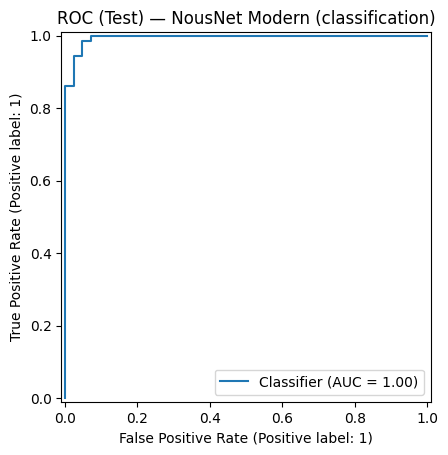

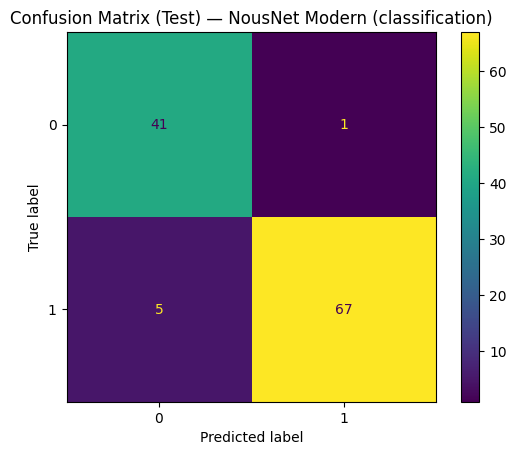

In [7]:
# Visualize ROC + confusion matrix for Modern model
probs = predict_proba_clf(nous_modern_clf, Xc_te)[:, 1]
RocCurveDisplay.from_predictions(yc_te, probs)
plt.title("ROC (Test) — NousNet Modern (classification)")
plt.show()

cm = confusion_matrix(yc_te, (probs >= 0.5).astype(int))
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix (Test) — NousNet Modern (classification)")
plt.show()

## 4) NousNet Simple — Interpretability demo (classification)

In [8]:
# Choose examples: random + most malignant-like by Simple model
probs_te_simple = predict_proba_clf(nous_simple_clf, Xc_te)[:, 1]
rng = np.random.default_rng(42)
rand_idxs = rng.choice(len(Xc_te), size=3, replace=False).tolist()
most_malig_idx = int(np.argmin(probs_te_simple))
example_idxs = list(dict.fromkeys(rand_idxs + [most_malig_idx]))

print("Example idxs:", example_idxs, "| most_malig_idx:", most_malig_idx, "| p(benign)=", float(probs_te_simple[most_malig_idx]))

Example idxs: [74, 9, 87, 104] | most_malig_idx: 104 | p(benign)= 0.0012227467959746718


In [9]:
# Enhanced explanation (human-readable)
for idx in example_idxs:
    x = Xc_te[idx]
    y_true = int(yc_te[idx])
    txt = generate_enhanced_explanation(
        nous_simple_clf,
        x_sample=x,
        y_true=y_true,
        feature_names=bc_feature_names,
        class_names=bc_class_names,
        loo_mode="replacement",
        top_m_rules=25,
        use_pruning=False,
    )
    print("\n" + "="*110)
    print(f"NousNet Simple | test_idx={idx} | y_true={bc_class_names[y_true]} | p(benign)={float(predict_proba_clf(nous_simple_clf, x[None,:])[0,1]):.4f}")
    print(txt)


NousNet Simple | test_idx=74 | y_true=malignant | p(benign)=0.0013
MODEL: SOFTMAX rules | TASK: CLASSIFICATION
SAMPLE PREDICTION: malignant
  - Confidence: 0.999
  - Ground Truth: malignant
------------------------------------------------------------
CAUSAL RULE IMPACT (Top 5):
  • B1/R18: Δmargin=+0.129 [+] | 0.33 AND + 0.35 OR + 0.33 k-of-n
    F62, F48  →  [F62] β( [L−R](x̃) = (0.33·texture error + 0.28·mean smoothness + 0.25·worst radius + 0.24·worst fractal dimension) − (0.34·smoothness error + 0.29·worst symmetry + 0.28·worst concavity + 0.23·mean fractal dimension) > 0.07; k=0.99, ν=0.70 ) | [F48] β( [L−R](x̃) = (0.25·mean texture + 0.23·worst concave points + 0.21·worst area + 0.20·worst concavity) − (0.26·compactness error + 0.22·worst symmetry + 0.18·mean radius + 0.18·mean concavity) > -0.04; k=0.99, ν=0.70 )
  • B1/R32: Δmargin=+0.092 [+] | 0.33 AND + 0.35 OR + 0.33 k-of-n
    F41, F52  →  [F41] β( [L−R](x̃) = (0.42·worst concave points + 0.30·area error + 0.30·worst perim

In [10]:
# Honest LOO rule impacts as DataFrame
idx = example_idxs[0]
df_imp = rule_impact_df(
    nous_simple_clf,
    x_sample=Xc_te[idx],
    feature_names=bc_feature_names,
    class_names=bc_class_names,
    loo_mode="replacement",
    top_m_rules=30,
)
display(df_imp.head(15))

,block,rule,aggregators,facts,Δlogit(pred),Δmargin(vs benign),supports_pred,critical_flip
0,1,18,0.33 AND + 0.35 OR + 0.33 k-of-n,"F62, F48 → [F62] β( [L−R](x̃) = (0.33·texture error + 0.28·mean smoothness + 0.25·worst radius + 0.24·worst fractal dimension) − (0.34·smoothness error + 0.29·worst symmetry + 0.28·worst concavity + 0.23·mean fractal dimension) > 0.07; k=0.99, ν=0.70 ) | [F48] β( [L−R](x̃) = (0.25·mean texture + 0.23·worst concave points + 0.21·worst area + 0.20·worst concavity) − (0.26·compactness error + 0.22·worst symmetry + 0.18·mean radius + 0.18·mean concavity) > -0.04; k=0.99, ν=0.70 )",0.040799,0.129184,True,False
1,1,32,0.33 AND + 0.35 OR + 0.33 k-of-n,"F41, F52 → [F41] β( [L−R](x̃) = (0.42·worst concave points + 0.30·area error + 0.30·worst perimeter + 0.25·mean area) − (0.28·texture error + 0.18·worst compactness + 0.17·mean smoothness + 0.13·fractal dimension error) > 0.01; k=1.01, ν=0.70 ) | [F52] β( [L−R](x̃) = (0.24·worst perimeter + 0.21·mean texture + 0.18·concavity error + 0.17·worst area) − (0.29·fractal dimension error + 0.21·mean compactness + 0.15·worst radius + 0.13·symmetry error) > -0.06; k=0.98, ν=0.69 )",0.078560,0.091989,True,False
2,1,16,0.34 AND + 0.33 OR + 0.33 k-of-n,"F16, F6 → [F16] β( [L−R](x̃) = (0.36·worst radius + 0.29·worst perimeter + 0.21·fractal dimension error + 0.20·worst area) − (0.33·concavity error + 0.28·compactness error + 0.19·worst concavity + 0.17·mean radius) > -0.05; k=0.98, ν=0.70 ) | [F6] β( [L−R](x̃) = (0.30·radius error + 0.27·concave points error + 0.23·worst symmetry + 0.17·mean smoothness) − (0.28·mean area + 0.23·mean fractal dimension + 0.23·compactness error + 0.19·mean compactness) > 0.06; k=0.99, ν=0.69 )",0.028022,0.048296,True,False
3,2,32,0.33 AND + 0.34 OR + 0.33 k-of-n,"F32, F36 → [F32] β( [L−R](x̃) = (0.34·mean radius + 0.28·mean concave points + 0.24·worst symmetry + 0.24·worst smoothness) − (0.23·symmetry error + 0.23·perimeter error + 0.22·concavity error + 0.22·worst compactness) > 0.19; k=0.96, ν=0.69 ) | [F36] β( [L−R](x̃) = (0.39·mean smoothness + 0.34·worst radius + 0.22·fractal dimension error + 0.21·worst compactness) − (0.25·radius error + 0.24·mean fractal dimension + 0.22·concavity error + 0.16·mean symmetry) > 0.11; k=0.99, ν=0.70 )",0.062744,0.046598,True,False
4,1,34,0.33 AND + 0.34 OR + 0.33 k-of-n,"F51, F40 → [F51] β( [L−R](x̃) = (0.34·worst perimeter + 0.30·worst area + 0.27·texture error + 0.26·worst texture) − (0.22·worst compactness + 0.15·fractal dimension error + 0.13·radius error + 0.11·smoothness error) > 0.09; k=0.99, ν=0.70 ) | [F40] β( [L−R](x̃) = (0.29·mean symmetry + 0.29·mean concavity + 0.26·worst perimeter + 0.19·worst texture) − (0.26·compactness error + 0.18·concave points error + 0.14·worst compactness + 0.14·worst concave points) > 0.00; k=0.97, ν=0.70 )",0.031304,0.046517,True,False
5,2,17,0.34 AND + 0.33 OR + 0.33 k-of-n,"F13, F52 → [F13] β( [L−R](x̃) = (0.31·worst compactness + 0.30·worst area + 0.27·symmetry error + 0.18·worst radius) − (0.21·worst fractal dimension + 0.19·compactness error + 0.17·smoothness error + 0.15·worst texture) > -0.08; k=0.96, ν=0.69 ) | [F52] β( [L−R](x̃) = (0.24·worst perimeter + 0.21·mean texture + 0.18·concavity error + 0.17·worst area) − (0.29·fractal dimension error + 0.21·mean compactness + 0.15·worst radius + 0.13·symmetry error) > -0.06; k=0.98, ν=0.69 )",0.012974,0.020432,True,False
6,1,31,0.34 AND + 0.33 OR + 0.33 k-of-n,"F36, F52 → [F36] β( [L−R](x̃) = (0.39·mean smoothness + 0.34·worst radius + 0.22·fractal dimension error + 0.21·worst compactness) − (0.25·radius error + 0.24·mean fractal dimension + 0.22·concavity error + 0.16·mean symmetry) > 0.11; k=0.99, ν=0.70 ) | [F52] β( [L−R](x̃) = (0.24·worst perimeter + 0.21·mean texture + 0.18·concavity error + 0.17·worst area) − (0.29·fractal dimension error + 0.21·mean compactness + 0.15·worst radius + 0.13·symmetry error) > -0.06; k=0.98, ν=0.69 )",0.009565,0.018313,True,False
7,2,31,0.33 AND + 0.34 OR + 0.33 k-of-n,"F

In [11]:
# Minimal sufficient explanation + fidelity + stability
idx = example_idxs[0]

mse = minimal_sufficient_explanation(
    nous_simple_clf,
    x_sample=Xc_te[idx],
    feature_names=bc_feature_names,
    class_names=bc_class_names,
    margin_tolerance=0.0,
    prob_tolerance=0.0,
    freeze_non_active=True,
)
print("MSE size:", mse["size"])
print("Kept sample:", mse["kept"][:10])
print("Removed count:", len(mse["removed"]))

fid = explanation_fidelity_metrics(
    nous_simple_clf,
    x_sample=Xc_te[idx],
    feature_names=bc_feature_names,
    class_names=bc_class_names,
)
print("Fidelity:", fid)

stab = explanation_stability(
    nous_simple_clf,
    x_sample=Xc_te[idx],
    feature_names=bc_feature_names,
    class_names=bc_class_names,
    k_top=5,
    sigma=0.05,
    trials=15,
    loo_mode="frozen",
)
print("Stability:", stab)

MSE size: 6
Kept sample: [(1, 17), (1, 18), (1, 34), (1, 52), (2, 11), (2, 17)]
Removed count: 10
Fidelity: {'base_margin': 6.680430889129639, 'sufficiency_margin': 6.710054397583008, 'comprehensiveness_margin': 6.415431022644043, 'kept_size': 6.0}
Stability: {'mean_jaccard': 0.7999999999999999, 'std_jaccard': 0.16329931618554525, 'base_top_rules': [(1, 18), (1, 34), (2, 32), (1, 32), (1, 16)]}


In [12]:
# Global rulebook (aggregate across samples)
gb = global_rulebook(
    nous_simple_clf,
    Xc_te[:200],
    feature_names=bc_feature_names,
    class_names=bc_class_names,
    max_samples=200,
    device=DEVICE,
)
display(gb.head(15))

Analyzing samples:   0%|          | 0/114 [00:00<?, ?it/s]

,block,rule,aggregators,activation_freq,mean_abs_impact,critical_rate
0,1,48,0.34 AND + 0.33 OR + 0.33 k-of-n,0.017544,2.297015,0.500000
1,1,57,0.36 AND + 0.33 OR + 0.32 k-of-n,0.008772,1.060798,0.000000
2,1,39,0.34 AND + 0.33 OR + 0.33 k-of-n,0.078947,0.560681,0.000000
3,1,47,0.33 AND + 0.33 OR + 0.33 k-of-n,0.078947,0.549552,0.000000
4,1,54,0.33 AND + 0.35 OR + 0.33 k-of-n,0.105263,0.484294,0.000000
5,1,56,0.34 AND + 0.33 OR + 0.33 k-of-n,0.070175,0.436889,0.000000
6,1,24,0.35 AND + 0.33 OR + 0.32 k-of-n,0.052632,0.405380,0.000000
7,1,10,0.34 AND + 0.33 OR + 0.33 k-of-n,0.114035,0.397647,0.000000
8,1,63,0.33 AND + 0.33 OR + 0.33 k-of-n,0.078947,0.393332,0.000000
9,1,50,0.34 AND + 0.33 OR + 0.33 k-of-n,0.052632,0.352020,0.000000


## 5) NousNet Modern — Advanced features demo (classification)

In [13]:
# Aggregator mixture report (distribution of AND/OR/k-of-n/NOT mixtures across samples)
agg_df = aggregator_mixture_report(nous_modern_clf, Xc_te[:50], max_samples=50, device=DEVICE)
display(agg_df)

,AND,OR,k-of-n,entropy
0,0.332773,0.334364,0.33286,1.097443


In [14]:
# Prototype explanations (Modern has use_prototypes=True)
idx = example_idxs[0]
proto_df = prototype_contribution_df(
    nous_modern_clf,
    Xc_te[idx],
    class_names=bc_class_names,
    top_k=5,
    device=DEVICE,
)
display(proto_df)

,proto,distance,activation,w_c,contribution,primary_class,entropy
0,0,0.120093,0.838185,-1.273437,-1.067376,malignant,0.654159
1,8,0.110261,0.850386,1.184665,1.007422,malignant,0.551447
2,5,0.107806,0.853459,0.790799,0.674914,malignant,0.519948
3,1,0.102256,0.860451,0.545112,0.469042,malignant,0.317942
4,4,0.786841,0.314577,1.137870,0.357948,malignant,0.681829


In [15]:
# Global prototype report (keep subset small)
proto_global = prototype_report_global(
    nous_modern_clf,
    Xc_tr[:300],
    y=yc_tr[:300],
    class_names=bc_class_names,
    top_k_rules=6,
    top_k_facts_per_rule=2,
    trace_to_base=True,
    k_neighbors=5,
    chunk_size=256,
    device=DEVICE,
)
display(proto_global.head(5))

,proto,primary_class,class_probs,class_weights,class_entropy,mean_activation,top1_count,neighbors,neighbor_labels,top_rules_meta
0,0,malignant,"[0.6387056112289429, 0.36129438877105713]","[-1.2734373807907104, -1.843187928199768]",0.654159,0.328522,0,"[73, 51, 215, 25, 10]","[0, 0, 0, 0, 0]","[{'rule': 21, 'weight': 0.2192848026752472, 'aggregators': '0.31 AND + 0.35 OR + 0.34 k-of-n', 'facts': '[F33] β( [L−R](x̃) = (0.21·worst perimeter + 0.21·mean concave points + 0.20·mean symmetry + 0.15·worst radius) − (0.28·concavity error + 0.23·worst fractal dimension + 0.16·compactness error + 0.14·mean radius) > 0.17; k=0.98, ν=0.76 ) where x̃ are calibrated features | [F37] β( [L−R](x̃) = (0.23·worst area + 0.19·worst texture + 0.12·radius error + 0.10·mean concavity) − (0.33·mean radius + 0.32·worst perimeter + 0.32·concavity error + 0.27·mean perimeter) > 0.18; k=1.02, ν=0.74 ) where x̃ are calibrated features'}, {'rule': 24, 'weight': -0.18554897606372833, 'aggregators': '0.34 AND + 0.35 OR + 0.32 k-of-n', 'facts': '[F28] β( [L−R](x̃) = (0.39·concavity error + 0.31·texture error + 0.30·worst compactness + 0.24·mean perimeter) − (0.32·worst perimeter + 0.26·worst concavity + 0.22·worst smoothness + 0.22·area error) > -0.20; k=1.04, ν=0.66 ) where x̃ are calibrated features | [F44] β( [L−R](x̃) = (0.38·compactness error + 0.37·concavity error + 0.26·mean perimeter + 0.15·symmetry error) − (0.37·mean concave points + 0.35·mean concavity + 0.26·worst area + 0.24·concave points error) > -0.14; k=1.03, ν=0.66 ) where x̃ are calibrated features'}, {'rule': 19, 'weight': -0.17192283272743225, 'aggregators': '0.33 AND + 0.35 OR + 0.32 k-of-n', 'facts': '[F28] β( [L−R](x̃) = (0.39·concavity error + 0.31·texture error + 0.30·worst compactness + 0.24·mean perimeter) − (0.32·worst perimeter + 0.26·worst concavity + 0.22·worst smoothness + 0.22·area error) > -0.20; k=1.04, ν=0.66 ) where x̃ are calibrated features | [F44] β( [L−R](x̃) = (0.38·compactness error + 0.37·concavity error + 0.26·mean perimeter + 0.15·symmetry error) − (0.37·mean concave points + 0.35·mean concavity + 0.26·worst area + 0.24·concave points error) > -0.14; k=1.03, ν=0.66 ) where x̃ are calibrated features'}, {'rule': 6, 'weight': 0.16641896963119507, 'aggregators': '0.32 AND + 0.35 OR + 0.33 k-of-n', 'facts': '[F6] β( [L−R](x̃) = (0.35·radius error + 0.29·concave points error + 0.16·mean smoothness + 0.09·perimeter error) − (0.40·mean area + 0.39·compactness error + 0.34·worst concavity + 0.30·mean compactness) > 0.10; k=1.06, ν=0.74 ) where x̃ are calibrated features | [F15] β( [L−R](x̃) = (0.24·worst texture + 0.20·mean fractal dimension + 0.20·worst symmetry + 0.19·radius error) − (0.31·worst compactness + 0.25·worst fractal dimension + 0.23·concavity error + 0.22·mean radius) > 0.01; k=0.96, ν=0.69 ) where x̃ are calibrated features'}, {'rule': 20, 'weight': -0.15603885054588318, 'aggregators': '0.34 AND + 0.33 OR + 0.33 k-of-n', 'facts': '[F16] β( [L−R](x̃) = (0.38·worst radius + 0.34·perimeter error + 0.34·fractal dimension error + 0.32·worst perimeter) − (0.24·concavity error + 0.17·worst concavity + 0.15·worst concave points + 0.13·mean texture) > -0.10; k=1.01, ν=0.67 ) where x̃ are calibrated features | [F28] β( [L−R](x̃) = (0.39·concavity error + 0.31·texture error + 0.30·worst compactness + 0.24·mean perimeter) − (0.32·worst perimeter + 0.26·worst concavity + 0.22·worst smoothness + 0.22·area error) > -0.20; k=1.04, ν=0.66 ) where x̃ are calibrated features'}, {'rule': 28, 'weight': 0.15178169310092926, 'aggregators': '0.32 AND + 0.35 OR + 0.33 k-of-n', 'facts': '[F6] β( [L−R](x̃) = (0.35·radius error + 0.29·concave points error + 0.16·mean smoothness + 0.09·perimeter error) − (0.40·mean area + 0.39·compactness error + 0.34·worst concavity + 0.30·mean compactness) > 0.10; k=1.06, ν=0.74 ) where x̃ are calibrated features | [F24] β( [L−R](x̃) = (0.36·mean fractal dimension + 0.32·mean area + 0.29·mean texture + 0.26·worst smoothness) − (0.35·compactness erro

In [16]:
# Select pruning threshold that preserves prediction fidelity and show pruned explanation
t_prune = select_pruning_threshold_global(
    nous_modern_clf,
    X_val=Xc_va[:200],
    target_fidelity=0.99,
    max_samples=200,
    device=DEVICE,
)
print("Selected pruning threshold:", float(t_prune))

idx = example_idxs[0]
txt_pruned = generate_enhanced_explanation(
    nous_modern_clf,
    x_sample=Xc_te[idx],
    y_true=int(yc_te[idx]),
    feature_names=bc_feature_names,
    class_names=bc_class_names,
    loo_mode="replacement",
    top_m_rules=25,
    use_pruning=True,
    pruning_threshold=float(t_prune),
)
print(txt_pruned)

Selected pruning threshold: 0.03787412174666921
MODEL: SOFT_FACT rules | TASK: CLASSIFICATION
SAMPLE PREDICTION: malignant
  - Confidence: 0.985
  - Ground Truth: malignant
  - Pruning: |act| >= 0.0379 (forward uses pruned activations)
------------------------------------------------------------
No active rules above threshold.


In [17]:
# Counterfactual suggestions guided by rule impacts and beta-fact geometry
idx = example_idxs[0]
cf = suggest_rule_counterfactuals(
    nous_modern_clf,
    x_sample=Xc_te[idx],
    feature_names=bc_feature_names,
    class_names=bc_class_names,
    target="flip",
    k_rules=3,
    top_m_rules=20,
    loo_mode="frozen",
    device=DEVICE,
)
display(pd.DataFrame(cf))

,rule,facts,deltas,verified,new_out
0,"(1, 38)","[F16, F44]","[(worst radius, -26.273155212402344), (perimeter error, -19.296489715576172), (mean concave points, 0.2989809513092041), (compactness error, -0.1954137682914734)]",False,None
1,"(1, 64)","[F30, F50]","[(worst smoothness, -41.91088104248047), (worst concave points, -10.257898330688477), (compactness error, -5.699665069580078), (worst symmetry, -5.387706756591797)]",False,None
2,"(1, 15)","[F24, F54]","[(worst texture, -6.913796901702881), (mean fractal dimension, -3.4236984252929688), (concavity error, 3.006012201309204), (compactness error, 2.9042389392852783)]",False,None


In [18]:
# NumPy export + parity check vs PyTorch
X_check = Xc_te[:64].astype(np.float32)
with tempfile.TemporaryDirectory() as td:
    path = os.path.join(td, "nous_numpy_infer.py")
    export_numpy_inference(nous_modern_clf, file_path=path)
    npmod = load_numpy_module(path)
    res = validate_numpy_vs_torch(nous_modern_clf, npmod, X_check, task="classification", n=64)
    print(res)

{'fidelity_info': 1.0, 'max_abs_prob_diff': 4.76837158203125e-07, 'mean_abs_prob_diff': 4.5510205382015556e-08, 'mean_L1_prob': 9.102041076403111e-08, 'mean_JS': -1.072542610280891e-09, 'max_abs_centered_logit_diff': 8.58306884765625e-06, 'pass': True}


## 6) Train NousNet Simple / Modern (regression) + explanations

In [19]:
t0 = time.time()
nous_simple_reg = fit_nousnet_reg(
    Xr_tr, yr_tr, Xr_va, yr_va,
    ca_feature_names,
    kind="simple",
    seed=CFG.seed,
    epochs=CFG.epochs_reg,
    patience=CFG.patience_reg,
    batch_size=CFG.batch_reg,
    lr=CFG.lr,
)
print("NousNet Simple (reg) train_time_s:", time.time() - t0)
print("Test:", eval_reg(nous_simple_reg, Xr_te, yr_te, y_scaler=ca_yscaler))

t0 = time.time()
nous_modern_reg = fit_nousnet_reg(
    Xr_tr, yr_tr, Xr_va, yr_va,
    ca_feature_names,
    kind="modern",
    seed=CFG.seed,
    epochs=CFG.epochs_reg + 40,
    patience=CFG.patience_reg + 10,
    batch_size=CFG.batch_reg,
    lr=CFG.lr,
)
print("NousNet Modern (reg) train_time_s:", time.time() - t0)
print("Test:", eval_reg(nous_modern_reg, Xr_te, yr_te, y_scaler=ca_yscaler))

Epoch [1/700] train=0.3485 val=0.3144 l0=0.0000 (*)
Epoch [2/700] train=0.2870 val=0.2967 l0=0.0000 (*)
Epoch [3/700] train=0.2709 val=0.2908 l0=0.0000 (*)
Epoch [5/700] train=0.2520 val=0.2724 l0=0.0000 (*)
Epoch [7/700] train=0.2467 val=0.2595 l0=0.0000 (*)
Epoch [10/700] train=0.2415 val=0.2592 l0=0.0000 (*)
Epoch [11/700] train=0.2391 val=0.2586 l0=0.0000 (*)
Epoch [12/700] train=0.2376 val=0.2580 l0=0.0000 (*)
Epoch [13/700] train=0.2361 val=0.2559 l0=0.0000 (*)
Epoch [14/700] train=0.2345 val=0.2546 l0=0.0000 (*)
Epoch [17/700] train=0.2305 val=0.2461 l0=0.0000 (*)
Epoch [20/700] train=0.2281 val=0.2461 l0=0.0000 (*)
Epoch [21/700] train=0.2277 val=0.2459 l0=0.0000 (*)
Epoch [22/700] train=0.2261 val=0.2451 l0=0.0000 (*)
Epoch [29/700] train=0.2270 val=0.2439 l0=0.0000 (*)
Epoch [30/700] train=0.2241 val=0.2416 l0=0.0000 (*)
Epoch [32/700] train=0.2227 val=0.2411 l0=0.0000 (*)
Epoch [35/700] train=0.2227 val=0.2376 l0=0.0000 (*)
Epoch [40/700] train=0.2207 val=0.2399 l0=0.0000
Ep

In [20]:
# Regression explanation: Δprediction impacts
idx = 0
x = Xr_te[idx]
y_true = float(yr_te[idx])

txt = generate_enhanced_explanation(
    nous_modern_reg,
    x_sample=x,
    y_true=y_true,
    feature_names=ca_feature_names,
    class_names=None,
    y_scaler=ca_yscaler,
    loo_mode="replacement",
    top_m_rules=20,
    use_pruning=False,
)
print(txt)

df_imp_reg = rule_impact_df(
    nous_modern_reg,
    x_sample=x,
    feature_names=ca_feature_names,
    loo_mode="replacement",
    top_m_rules=20,
)
display(df_imp_reg.head(12))

MODEL: SOFT_FACT rules | TASK: REGRESSION
SAMPLE PREDICTION: Value: 0.478
  - Ground Truth: 0.477
------------------------------------------------------------
CAUSAL RULE IMPACT (Top 5):
  • B1/R59: Δprediction=-0.015 | 0.09 AND + 0.37 OR + 0.54 k-of-n
    F8 (w=0.23), F62 (w=0.11)  →  [F8] β( [L−R](x̃) = (6.62·AveBedrms + 2.07·Population + 1.75·AveRooms + 0.44·Latitude) − (0.44·AveOccup + 0.37·Longitude) > -0.98; k=5.47, ν=0.90 )  where x̃ are calibrated features | [F62] β( [L−R](x̃) = (3.04·Population + 2.31·Latitude + 0.91·AveOccup + 0.77·AveRooms) − (1.24·HouseAge + 0.17·MedInc) > -0.80; k=4.21, ν=0.79 )  where x̃ are calibrated features
  • B1/R30: Δprediction=+0.014 | 0.19 AND + 0.33 OR + 0.48 k-of-n
    F52 (w=0.12), F32 (w=0.11)  →  [F52] β( [L−R](x̃) = (3.17·Latitude + 0.19·MedInc + 0.14·AveOccup) − (1.40·Longitude + 0.22·AveRooms + 0.04·HouseAge) > -0.69; k=6.17, ν=0.22 )  where x̃ are calibrated features | [F32] β( [L−R](x̃) = (2.28·AveBedrms + 2.00·Population + 0.68·AveRoom

,block,rule,aggregators,facts,Δprediction
0,1,59,0.09 AND + 0.37 OR + 0.54 k-of-n,"F8 (w=0.23), F62 (w=0.11) → [F8] β( [L−R](x̃) = (6.62·AveBedrms + 2.07·Population + 1.75·AveRooms + 0.44·Latitude) − (0.44·AveOccup + 0.37·Longitude) > -0.98; k=5.47, ν=0.90 ) where x̃ are calibrated features | [F62] β( [L−R](x̃) = (3.04·Population + 2.31·Latitude + 0.91·AveOccup + 0.77·AveRooms) − (1.24·HouseAge + 0.17·MedInc) > -0.80; k=4.21, ν=0.79 ) where x̃ are calibrated features",-0.012708
1,1,30,0.19 AND + 0.33 OR + 0.48 k-of-n,"F52 (w=0.12), F32 (w=0.11) → [F52] β( [L−R](x̃) = (3.17·Latitude + 0.19·MedInc + 0.14·AveOccup) − (1.40·Longitude + 0.22·AveRooms + 0.04·HouseAge) > -0.69; k=6.17, ν=0.22 ) where x̃ are calibrated features | [F32] β( [L−R](x̃) = (2.28·AveBedrms + 2.00·Population + 0.68·AveRooms + 0.34·MedInc) − (1.06·Longitude + 0.94·Latitude + 0.17·AveOccup) > 0.11; k=1.75, ν=1.04 ) where x̃ are calibrated features",0.012287
2,1,18,0.26 AND + 0.38 OR + 0.36 k-of-n,"F55 (w=0.11), F27 (w=0.10) → [F55] β( [L−R](x̃) = (0.70·AveRooms + 0.66·MedInc + 0.60·Population + 0.55·Latitude) − (0) > 1.33; k=0.70, ν=1.59 ) where x̃ are calibrated features | [F27] β( [L−R](x̃) = (6.16·Longitude + 0.06·MedInc) − (0.11·AveRooms + 0.08·Latitude) > 0.76; k=5.46, ν=2.07 ) where x̃ are calibrated features",-0.011144
3,1,15,0.14 AND + 0.31 OR + 0.54 k-of-n,"F20 (w=0.14), F52 (w=0.10) → [F20] β( [L−R](x̃) = (0.96·Latitude + 0.80·AveRooms + 0.67·Population + 0.25·AveOccup) − (1.37·AveBedrms + 1.14·Longitude + 0.69·HouseAge + 0.18·MedInc) > -1.52; k=2.09, ν=0.54 ) where x̃ are calibrated features | [F52] β( [L−R](x̃) = (3.17·Latitude + 0.19·MedInc + 0.14·AveOccup) − (1.40·Longitude + 0.22·AveRooms + 0.04·HouseAge) > -0.69; k=6.17, ν=0.22 ) where x̃ are calibrated features",0.011076
4,1,22,0.17 AND + 0.27 OR + 0.56 k-of-n,"F20 (w=0.13), F43 (w=0.11) → [F20] β( [L−R](x̃) = (0.96·Latitude + 0.80·AveRooms + 0.67·Population + 0.25·AveOccup) − (1.37·AveBedrms + 1.14·Longitude + 0.69·HouseAge + 0.18·MedInc) > -1.52; k=2.09, ν=0.54 ) where x̃ are calibrated features | [F43] β( [L−R](x̃) = (0.87·Latitude + 0.32·AveOccup + 0.30·AveRooms) − (2.98·Longitude + 0.35·MedInc + 0.14·Population + 0.12·AveBedrms) > 0.34; k=1.79, ν=0.50 ) where x̃ are calibrated features",0.008186
5,1,28,0.17 AND + 0.30 OR + 0.53 k-of-n,"F32 (w=0.10), F52 (w=0.10) → [F32] β( [L−R](x̃) = (2.28·AveBedrms + 2.00·Population + 0.68·AveRooms + 0.34·MedInc) − (1.06·Longitude + 0.94·Latitude + 0.17·AveOccup) > 0.11; k=1.75, ν=1.04 ) where x̃ are calibrated features | [F52] β( [L−R](x̃) = (3.17·Latitude + 0.19·MedInc + 0.14·AveOccup) − (1.40·Longitude + 0.22·AveRooms + 0.04·HouseAge) > -0.69; k=6.17, ν=0.22 ) where x̃ are calibrated features",0.006915
6,1,47,0.26 AND + 0.37 OR + 0.36 k-of-n,"F39 (w=0.10), F11 (w=0.09) → [F39] β( [L−R](x̃) = (1.63·Latitude + 1.36·Longitude + 0.12·AveRooms + 0.10·AveOccup) − (0.95·Population + 0.61·MedInc + 0.28·HouseAge + 0.24·AveBedrms) > 0.50; k=1.33, ν=1.16 ) where x̃ are calibrated features | [F11] β( [L−R](x̃) = (1.32·MedInc + 1.00·AveRooms + 0.76·AveBedrms + 0.64·Population) − (0.79·AveOccup + 0.06·Longitude) > 1.47; k=1.24, ν=1.75 ) where x̃ are calibrated features",-0.006700
7,1,37,0.16 AND + 0.43 OR + 0.42 k-of-n,"F55 (w=0.21), F42 (w=0.13) → [F55] β( [L−R](x̃) = (0.70·AveRooms + 0.66·MedInc + 0.60·Population + 0.55·Latitude) − (0) > 1.33; k=0.70, ν=1.59 ) where x̃ are calibrated features | [F42] β( [L−R](x̃) = (4.03·AveRooms + 1.32·MedInc + 0.80·Longitude + 0.65·AveBedrms) − (0.78·Population) > -0.66; k=2.50, ν=0.81 ) where x̃ are calibrated features",-0.005412
8,1,13,0.17 AND + 0.41 OR + 0.42 k-of-n,"F55 (w=0.20), F12 (w=0.12) → [F55] β( [L−R](x̃) = (0.70·AveRooms + 0.66·MedInc + 0.60·Population + 0.55·Latitude) − (0) > 1.33; k=0.70, ν=1.59 ) where x̃ are calibrated features | [F12] β( [L−R](x̃) = (2.03·MedInc + 1.08·HouseAge + 0.88·AveRooms + 0.46·AveBedrms) − (0.47·Longitude + 0.42·Latitude) > 0.53; k=1.14, ν=0.99 ) where x̃ are calibrated features",-0.00

## 7) Model Zoo — training + interpretations (Breast Cancer)
Zoo models output a single binary logit (shape [B]) and come with separate explain helpers.

In [21]:
def train_binary_logit_model(
    model: nn.Module,
    X_tr: np.ndarray,
    y_tr: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    epochs: int = 200,
    patience: int = 40,
    batch_size: int = 128,
    lr: float = 2e-3,
    weight_decay: float = 1e-4,
    clip_grad: float = 0.5,
    desc: str = "train",
) -> nn.Module:
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=float(lr), weight_decay=float(weight_decay))
    crit = torch.nn.BCEWithLogitsLoss()

    Xtr_t = torch.tensor(X_tr, dtype=torch.float32)
    ytr_t = torch.tensor(y_tr, dtype=torch.float32)
    Xva_t = torch.tensor(X_val, dtype=torch.float32)
    yva_t = torch.tensor(y_val, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=int(batch_size), shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=int(batch_size), shuffle=False)

    best = float("inf")
    best_state = None
    no_imp = 0

    pbar = tqdm(range(int(epochs)), desc=desc, leave=False)
    for _ in pbar:
        model.train()
        tr = 0.0
        nb = 0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE).view(-1)
            opt.zero_grad(set_to_none=True)

            logit = model(xb).view(-1)
            loss = crit(logit, yb)
            loss.backward()
            if clip_grad is not None:
                nn_utils.clip_grad_norm_(model.parameters(), float(clip_grad))
            opt.step()

            tr += float(loss.item()); nb += 1
        tr /= max(1, nb)

        model.eval()
        va = 0.0
        nb = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE).view(-1)
                logit = model(xb).view(-1)
                loss = crit(logit, yb)
                va += float(loss.item()); nb += 1
        va /= max(1, nb)

        pbar.set_postfix({"tr": f"{tr:.4f}", "val": f"{va:.4f}", "no_imp": f"{no_imp}/{patience}"})

        if va < best - 1e-9:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= int(patience):
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

@torch.no_grad()
def zoo_predict_proba(model: nn.Module, X: np.ndarray) -> np.ndarray:
    model.eval()
    xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    logit = model(xt).view(-1).detach().cpu().numpy()
    return 1.0 / (1.0 + np.exp(-logit))

def zoo_eval(model: nn.Module, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    p1 = zoo_predict_proba(model, X)
    pred = (p1 >= 0.5).astype(int)
    return {
        "acc": float(accuracy_score(y, pred)),
        "auc": float(roc_auc_score(y, p1)),
        "f1": float(f1_score(y, pred)),
    }

In [22]:
seed_everything(42)

zoo_models: Dict[str, nn.Module] = {}

m = SoftLogitAND(input_dim=Xc_tr.shape[1], n_rules=64, n_thresh_per_feat=6).to(DEVICE)
m.init_from_data(Xc_tr)
zoo_models["SoftLogitAND"] = train_binary_logit_model(m, Xc_tr, yc_tr, Xc_va, yc_va, epochs=200, patience=40, desc="SoftLogitAND")

m = SoftLogicInteraction(input_dim=Xc_tr.shape[1], n_rules=64, n_thresh_per_feat=6, n_inter=24).to(DEVICE)
m.init_from_data(Xc_tr)
zoo_models["SoftLogicInteraction"] = train_binary_logit_model(m, Xc_tr, yc_tr, Xc_va, yc_va, epochs=200, patience=40, desc="SoftLogicInteraction")

m = SegmentMoE(input_dim=Xc_tr.shape[1], feature_names=bc_feature_names, n_segments=6, n_thresh_per_feat=6).to(DEVICE)
m.init_from_data(Xc_tr)
zoo_models["SegmentMoE"] = train_binary_logit_model(m, Xc_tr, yc_tr, Xc_va, yc_va, epochs=220, patience=45, desc="SegmentMoE")

m = HierarchicalMoE(input_dim=Xc_tr.shape[1], feature_names=bc_feature_names, n_segments=5, n_rules_expert=24, n_thresh_per_feat=6).to(DEVICE)
m.init_from_data(Xc_tr)
zoo_models["HierarchicalMoE"] = train_binary_logit_model(m, Xc_tr, yc_tr, Xc_va, yc_va, epochs=240, patience=50, desc="HierarchicalMoE")

m = NousFamilies(input_dim=Xc_tr.shape[1], feature_names=bc_feature_names, num_facts=64, rules_per_layer=(48, 24), n_families=12).to(DEVICE)
m.init_from_data(Xc_tr)
zoo_models["NousFamilies"] = train_binary_logit_model(m, Xc_tr, yc_tr, Xc_va, yc_va, epochs=240, patience=50, desc="NousFamilies")

rows = []
for name, model in zoo_models.items():
    rows.append({"model": name, **zoo_eval(model, Xc_te, yc_te)})
zoo_metrics = pd.DataFrame(rows).sort_values("auc", ascending=False).reset_index(drop=True)
display(zoo_metrics)

,model,acc,auc,f1
0,HierarchicalMoE,0.956140,0.996693,0.964539
1,SoftLogicInteraction,0.956140,0.995701,0.964539
2,SegmentMoE,0.973684,0.995701,0.979021
3,SoftLogitAND,0.956140,0.995040,0.964539
4,NousFamilies,0.964912,0.989749,0.972222


In [23]:
# Pick a couple of Zoo examples
p1 = zoo_predict_proba(zoo_models["HierarchicalMoE"], Xc_te)
idx_low = int(np.argmin(p1))   # malignant-like (low P(benign))
idx_high = int(np.argmax(p1))  # benign-like
zoo_examples = [idx_low, idx_high]
print("Zoo examples:", zoo_examples, "| p1(low)=", float(p1[idx_low]), "| p1(high)=", float(p1[idx_high]))

Zoo examples: [101, 72] | p1(low)= 4.9513313570059836e-05 | p1(high)= 0.9996600151062012


In [24]:
# SoftLogitAND: global + local
m = zoo_models["SoftLogitAND"]
print("\n[Zoo] SoftLogitAND — Global rules:")
display(softlogitand_global_rules_df(m, bc_feature_names, scaler=bc_scaler, top_rules=10, top_facts_per_rule=3))

idx = zoo_examples[0]
print("\n[Zoo] SoftLogitAND — Local rule contributions:")
df_loc, meta = softlogitand_local_contrib_df(m, Xc_te[idx], bc_feature_names, scaler=bc_scaler, top_rules=10, top_facts_per_rule=3)
print("meta:", meta)
display(df_loc)


[Zoo] SoftLogitAND — Global rules:


,rule,weight,abs_weight,rule_text,top_conditions
0,41,-0.443663,0.443663,worst concave points > 0.05971 AND worst texture > 15.69 AND worst texture > 29.74,worst concave points > 0.05971 (p=0.011) | worst texture > 15.69 (p=0.011) | worst texture > 29.74 (p=0.011)
1,52,-0.440073,0.440073,worst texture > 19.03 AND worst area > 347.5 AND area error > 27.82,worst texture > 19.03 (p=0.011) | worst area > 347.5 (p=0.011) | area error > 27.82 (p=0.011)
2,51,0.430979,0.430979,mean perimeter <= 74.53 AND worst radius <= 15.91 AND worst concave points <= 0.08235,mean perimeter <= 74.53 (p=0.010) | worst radius <= 15.91 (p=0.009) | worst concave points <= 0.08235 (p=0.009)
3,0,0.427219,0.427219,worst texture <= 19.03 AND worst texture <= 26.61 AND worst radius <= 15.91,worst texture <= 19.03 (p=0.013) | worst texture <= 26.61 (p=0.009) | worst radius <= 15.91 (p=0.008)
4,1,-0.425833,0.425833,worst smoothness > 0.1157 AND worst texture > 19.03 AND worst radius > 18.78,worst smoothness > 0.1157 (p=0.013) | worst texture > 19.03 (p=0.012) | worst radius > 18.78 (p=0.011)
5,24,0.422943,0.422943,worst smoothness <= 0.1494 AND mean concave points <= 0.0075 AND worst texture <= 15.69,worst smoothness <= 0.1494 (p=0.015) | mean concave points <= 0.0075 (p=0.011) | worst texture <= 15.69 (p=0.011)
6,17,0.421481,0.421481,worst texture <= 29.74 AND worst concave points <= 0.08235 AND worst texture <= 15.69,worst texture <= 29.74 (p=0.010) | worst concave points <= 0.08235 (p=0.009) | worst texture <= 15.69 (p=0.009)
7,22,-0.420877,0.420877,worst texture > 22.17 AND radius error > 0.4959 AND worst perimeter > 83.97,worst texture > 22.17 (p=0.011) | radius error > 0.4959 (p=0.011) | worst perimeter > 83.97 (p=0.009)
8,46,-0.416648,0.416648,worst perimeter > 67.78 AND worst texture > 26.61 AND worst perimeter > 175.9,worst perimeter > 67.78 (p=0.013) | worst texture > 26.61 (p=0.012) | worst perimeter > 175.9 (p=0.010)
9,31,0.416306,0.416306,worst texture <= 36.27 AND area error <= 13.22 AND worst smoothness <= 0.1494,worst texture <= 36.27 (p=0.009) | area error <= 13.22 (p=0.009) | worst smoothness <= 0.1494 (p=0.008)



[Zoo] SoftLogitAND — Local rule contributions:
meta: {'logit': -10.670328140258789, 'prob_pos': 2.32233705901308e-05}


,rule,activation,weight,contribution_to_logit,rule_text
0,41,0.945148,-0.443663,-0.419327,worst concave points > 0.05971 AND worst texture > 15.69 AND worst texture > 29.74
1,52,0.945444,-0.440073,-0.416065,worst texture > 19.03 AND worst area > 347.5 AND area error > 27.82
2,1,0.955679,-0.425833,-0.406960,worst smoothness > 0.1157 AND worst texture > 19.03 AND worst radius > 18.78
3,46,0.961697,-0.416648,-0.400689,worst perimeter > 67.78 AND worst texture > 26.61 AND worst perimeter > 175.9
4,22,0.949040,-0.420877,-0.399430,worst texture > 22.17 AND radius error > 0.4959 AND worst perimeter > 83.97
5,28,0.961274,-0.409440,-0.393584,worst symmetry > 0.3062 AND perimeter error > 2.582 AND worst area > 347.5
6,36,0.951298,-0.413286,-0.393158,worst texture > 22.17 AND worst texture > 19.03 AND worst radius > 12.97
7,11,0.941136,-0.412256,-0.387988,worst radius > 15.91 AND worst symmetry > 0.2602 AND mean perimeter > 136.2
8,56,0.965880,-0.401529,-0.387829,worst radius > 12.97 AND worst texture > 22.17 AND worst smoothness > 0.1284
9,55,0.940187,-0.411550,-0.386934,worst texture > 22.17 AND worst radius > 15.91 AND worst texture > 19.03


In [25]:
# SegmentMoE: gate summary + local
m = zoo_models["SegmentMoE"]
print("\n[Zoo] SegmentMoE — Gate summary (avg segment probs):")
display(moe_gate_summary_df(m, Xc_va[:200]))

idx = zoo_examples[0]
print("\n[Zoo] SegmentMoE — Local gate + expert explanation:")
df_loc, meta = segmentmoe_local_explain_df(m, Xc_te[idx], bc_feature_names, scaler=bc_scaler, top_segments=3, top_facts=8)
print("meta:", meta)
display(df_loc)


[Zoo] SegmentMoE — Gate summary (avg segment probs):


,segment,avg_gate_prob
0,4,0.220842
1,5,0.217994
2,3,0.204401
3,1,0.135305
4,2,0.117124
5,0,0.104335



[Zoo] SegmentMoE — Local gate + expert explanation:
meta: {'logit': -16.120765686035156, 'prob_pos': 9.97333426829044e-08}


,segment,gate_prob,expert_logit,segment_contribution_to_logit,top_fact_contribs
0,3,0.423658,-18.969967,-8.036786,worst texture > 19.03: -0.248 | worst texture > 23.29: -0.247 | worst area > 553.2: -0.244 | worst radius > 13.59: -0.239 | worst texture > 25.41: -0.234 | perimeter error > 1.818: -0.226 | mean texture > 17.49: -0.225 | worst smoothness > 0.1419: -0.223
1,1,0.290691,-15.796261,-4.591831,worst texture > 23.29: -0.235 | mean texture > 17.49: -0.228 | mean texture > 15: -0.223 | worst area > 553.2: -0.217 | worst radius > 13.59: -0.213 | worst texture > 19.03: -0.212 | worst area > 699.5: -0.210 | worst concavity > 0.2152: -0.204
2,2,0.253855,-15.203773,-3.859550,worst texture > 23.29: -0.208 | worst area > 824: -0.208 | worst texture > 25.41: -0.202 | worst perimeter > 77.78: -0.202 | mean texture > 15: -0.197 | worst perimeter > 93.69: -0.195 | worst smoothness > 0.1419: -0.193 | mean texture > 17.49: -0.192


In [26]:
# HierarchicalMoE: gate summary + local (top expert rules)
m = zoo_models["HierarchicalMoE"]
print("\n[Zoo] HierarchicalMoE — Gate summary (avg segment probs):")
display(moe_gate_summary_df(m, Xc_va[:200]))

idx = zoo_examples[0]
print("\n[Zoo] HierarchicalMoE — Local gate + top expert rules:")
df_loc, meta = hiermoe_local_explain_df(m, Xc_te[idx], bc_feature_names, scaler=bc_scaler, top_segments=3, top_rules=6, top_facts_per_rule=3)
print("meta:", meta)
display(df_loc)


[Zoo] HierarchicalMoE — Gate summary (avg segment probs):


,segment,avg_gate_prob
0,3,0.379130
1,2,0.305188
2,0,0.240514
3,1,0.067268
4,4,0.007901



[Zoo] HierarchicalMoE — Local gate + top expert rules:
meta: {'logit': -9.913220405578613, 'prob_pos': 4.951326620917225e-05}


,segment,gate_prob,expert_logit,segment_contribution_to_logit,top_expert_rules
0,3,0.981131,-10.046936,-9.857359,[r4] -0.606: worst radius > 13.24 AND mean fractal dimension <= 0.08067 AND mean smoothness > 0.06882 || [r2] -0.596: radius error > 0.1081 AND worst area > 944.1 AND worst radius > 14.88 || [r18] -0.592: mean texture > 12.3 AND worst texture > 22.47 AND mean smoothness > 0.06882 || [r12] -0.591: mean fractal dimension <= 0.08067 AND symmetry error <= 0.04216 AND texture error <= 1.729 || [r11] -0.576: mean symmetry > 0.1293 AND compactness error <= 0.07554 AND mean perimeter > 68.14 || [r1] -0.572: worst perimeter > 64.81 AND worst texture > 22.47 AND worst smoothness > 0.114
1,4,0.017772,-3.509403,-0.062368,[r12] -0.326: worst radius > 19.31 AND mean radius > 11.19 AND worst compactness > 0.04373 || [r17] -0.317: mean texture > 18.16 AND mean smoothness > 0.098 AND fractal dimension error <= 0.009017 || [r22] -0.309: symmetry error <= 0.02944 AND worst concavity > 0.1879 AND mean texture > 12.3 || [r16] -0.308: concavity error > 0.01821 AND worst concave points > 0.1344 AND mean radius > 15.59 || [r8] -0.281: worst texture > 16.6 AND area error > 12.27 AND worst concave points > 0.02436 || [r2] -0.257: worst smoothness > 0.09332 AND worst compactness > 0.161 AND worst texture > 22.47
2,2,0.000438,6.370786,0.002789,[r10] +0.357: fractal dimension error > 0.0003507 AND mean fractal dimension > 0.05715 AND area error <= 120.8 || [r3] +0.327: symmetry error > 0.01646 AND concave points error <= 0.02544 AND texture error <= 1.729 || [r4] +0.324: mean texture <= 27.69 AND mean fractal dimension > 0.05415 AND texture error <= 2.52 || [r7] +0.321: texture error <= 1.729 AND fractal dimension error > 0.0006395 AND worst texture <= 37.87 || [r0] +0.305: mean fractal dimension <= 0.07092 AND mean perimeter <= 136.5 AND worst smoothness <= 0.1403 || [r18] +0.297: compactness error > 0.006882 AND fractal dimension error > 0.002286 AND texture error <= 1.729


In [27]:
# NousFamilies: global + local
m = zoo_models["NousFamilies"]
print("\n[Zoo] NousFamilies — Global families:")
display(nousfamilies_global_summary_df(m, top_families=10))

idx = zoo_examples[0]
print("\n[Zoo] NousFamilies — Local family contributions:")
df_loc, meta = nousfamilies_local_contrib_df(m, Xc_te[idx], top_families=8)
print("meta:", meta)
display(df_loc)


[Zoo] NousFamilies — Global families:


,family,weight_W,abs_weight,assigned_rule_mass
0,10,0.827271,0.827271,2.834254
1,6,0.740599,0.740599,2.725994
2,11,0.737809,0.737809,2.737624
3,9,0.727810,0.727810,2.792814
4,2,0.616173,0.616173,8.035124
5,5,0.613952,0.613952,7.415708
6,7,0.606889,0.606889,7.636438
7,1,0.606502,0.606502,7.814112
8,3,0.596835,0.596835,7.682950
9,8,0.596648,0.596648,7.632478



[Zoo] NousFamilies — Local family contributions:
meta: {'logit': -8.587051391601562, 'prob_pos': 0.0001864704308036553}


,family,family_activation,family_weight_W,family_contribution_to_logit
0,10,-2.821054,0.827271,-2.333775
1,6,-2.904901,0.740599,-2.151366
2,11,-2.909018,0.737809,-2.146301
3,9,-2.687495,0.727810,-1.955987
4,3,-0.104156,0.596835,-0.062164
5,4,-0.096452,0.593315,-0.057226
6,0,-0.101273,0.560005,-0.056713
7,1,-0.089125,0.606502,-0.054054


In [28]:
print(
    "\n[Zoo] SoftLogicInteraction note:\n"
    "- SoftLogicInteraction includes low-rank interaction facts (logit-space).\n"
    "- Those interaction facts do not map cleanly to single raw-feature threshold conditions.\n"
    "- Recommended: compare global performance vs SoftLogitAND and use model-agnostic tools (permutation importance / saliency).\n"
)


[Zoo] SoftLogicInteraction note:
- SoftLogicInteraction includes low-rank interaction facts (logit-space).
- Those interaction facts do not map cleanly to single raw-feature threshold conditions.
- Recommended: compare global performance vs SoftLogitAND and use model-agnostic tools (permutation importance / saliency).



## 8) Final scoreboard (NousNet + Zoo)

In [29]:
rows = []
rows.append({"model": "NousNet Simple (clf)", **eval_binary_clf(nous_simple_clf, Xc_te, yc_te)})
rows.append({"model": "NousNet Modern (clf)", **eval_binary_clf(nous_modern_clf, Xc_te, yc_te)})

reg_s = eval_reg(nous_simple_reg, Xr_te, yr_te, y_scaler=ca_yscaler)
reg_m = eval_reg(nous_modern_reg, Xr_te, yr_te, y_scaler=ca_yscaler)
rows.append({"model": "NousNet Simple (reg)", **reg_s})
rows.append({"model": "NousNet Modern (reg)", **reg_m})

for name, m in zoo_models.items():
    rows.append({"model": f"Zoo/{name}", **zoo_eval(m, Xc_te, yc_te)})

scoreboard = pd.DataFrame(rows)
display(scoreboard)

,model,acc,auc,f1,rmse,mae,r2
0,NousNet Simple (clf),0.964912,0.996362,0.971831,NaN,NaN,NaN
1,NousNet Modern (clf),0.947368,0.995040,0.957143,NaN,NaN,NaN
2,NousNet Simple (reg),NaN,NaN,NaN,0.515815,0.342604,0.796960
3,NousNet Modern (reg),NaN,NaN,NaN,0.497917,0.334463,0.810807
4,Zoo/SoftLogitAND,0.956140,0.995040,0.964539,NaN,NaN,NaN
5,Zoo/SoftLogicInteraction,0.956140,0.995701,0.964539,NaN,NaN,NaN
6,Zoo/SegmentMoE,0.973684,0.995701,0.979021,NaN,NaN,NaN
7,Zoo/HierarchicalMoE,0.956140,0.996693,0.964539,NaN,NaN,NaN
8,Zoo/NousFamilies,0.964912,0.989749,0.972222,NaN,NaN,NaN
